## 🧠 Deep Learning Summer School — Practical Lab: Day 4
**Topic**: Neural Network Optimization (From Scratch!)

📅 *Date: 22 May 2025 — 2:30 to 4:30 PM*

Welcome! In this notebook, we’ll roll up our sleeves and build a very simple (but powerful!) neural network completely from scratch — no frameworks, just raw NumPy.
We'll test it on the famous `make_moons` dataset and play around with training and hyperparameter tuning.

Let's go!

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_classification,load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
from IPython.display import display, clear_output

## 🌙 Why Use the `make_moons` Dataset?
`make_moons` is a fun little dataset that gives us two interleaved crescent-shaped classes. This is *perfect* for testing how a neural network handles non-linearly separable problems.

**Why it rocks:**
- Simple and 2D — easy to visualize decision boundaries 🧩
- Non-linear — which means linear classifiers (like logistic regression) will struggle 😅
- Includes optional noise — like real-world messy data 💥

So, it's a great test case for us!

In [5]:
# Set random seed for reproducibility
np.random.seed(42)

# =============================================
# Part 1: Implementing Gradient Descent
# =============================================

class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        # Initialize weights with Xavier/Glorot initialization
        self.W1 = np.random.randn(input_size, hidden_size)
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size)
        self.b2 = np.zeros((1, output_size))

        # self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2. / input_size)
        # self.b1 = np.zeros((1, hidden_size))
        # self.W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2. / hidden_size)
        # self.b2 = np.zeros((1, output_size))

        # For tracking loss and accuracy
        self.loss_history = []
        self.acc_history = []

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def forward(self, X):
        # Hidden layer
        self.z1 = np.dot(X, self.W1) + self.b1   # z1 = x * W1 + b1
        self.a1 = self.sigmoid(self.z1)          # a1 = sigmoid(z1)

        # Output layer
        self.z2 = np.dot(self.a1, self.W2) + self.b2  # dz2 = a1 * w2 + b2
        self.a2 = self.sigmoid(self.z2)               # a2 = sigmoid(z2)
        return self.a2

    def compute_loss(self, y, output):
        # Binary cross-entropy loss
        m = y.shape[0]
        loss = -np.mean(y * np.log(output + 1e-8) + (1 - y) * np.log(1 - output + 1e-8))
        return loss

    def backward(self, X, y, output, learning_rate):
        m = y.shape[0]

        # Output layer gradients
        dZ2 = (output - y)

        dW2 = np.dot(self.a1.T, dZ2) / m
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m

        # Hidden layer gradients
        da1 = np.dot(dZ2, self.W2.T)
        dZ1 = da1 * self.sigmoid_derivative(self.a1)
        dW1 = np.dot(X.T, dZ1) / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m

        # Update weights
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1

    def predict(self, X):
        output = self.forward(X)
        return (output > 0.5).astype(int)

    def accuracy(self, y_true, y_pred):
        return np.mean(y_true == y_pred)

    def train(self, X, y, X_val, y_val, epochs, learning_rate, batch_size=None, verbose=True):
        if batch_size is None:
            batch_size = X.shape[0]  # Full batch gradient descent

        n_batches = int(np.ceil(X.shape[0] / batch_size))

        for epoch in range(epochs):
            # Shuffle data
            indices = np.random.permutation(X.shape[0])
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            epoch_loss = 0

            for batch in range(n_batches):
                # Get batch
                start = batch * batch_size
                end = start + batch_size
                X_batch = X_shuffled[start:end]
                y_batch = y_shuffled[start:end]

                # Forward pass
                output = self.forward(X_batch)
                loss = self.compute_loss(y_batch, output)
                epoch_loss += loss

                # Backward pass and update weights
                self.backward(X_batch, y_batch, output, learning_rate)

            # Calculate average epoch loss
            epoch_loss /= n_batches
            self.loss_history.append(epoch_loss)

            # Calculate training and validation accuracy
            train_pred = self.predict(X)
            train_acc = self.accuracy(y, train_pred)

            val_pred = self.predict(X_val)
            val_acc = self.accuracy(y_val, val_pred)
            self.acc_history.append((train_acc, val_acc))

            if verbose and (epoch % (epochs//10) == 0 or epoch == epochs-1):
                print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")



In [6]:
# =============================================
# Part 2: Hyperparameter Tuning and Visualization
# =============================================

def generate_data(n_samples=1000, noise=0.2):
    # Generate non-linear dataset (moons)
    X, y = make_moons(n_samples=n_samples, noise=noise, random_state=42)
    # X, y = load_breast_cancer(return_X_y=True)
    print("X shape", X.shape, "Y_shape", y.shape)
    n_samples=X.shape[0]
    # Split into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    # Reshape y for our neural network
    y_train = y_train.reshape(-1, 1)
    y_val = y_val.reshape(-1, 1)

    return X_train, X_val, y_train, y_val

def plot_decision_boundary(model, X, y, title):
    # Create mesh grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    # Predict for each point in mesh grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), s=20, edgecolor='k')
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

def plot_training_history(loss_history, acc_history, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot loss
    ax1.plot(loss_history, label='Training Loss')
    ax1.set_title(f'{title} - Loss Curve')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot accuracy
    train_acc = [acc[0] for acc in acc_history]
    val_acc = [acc[1] for acc in acc_history]
    ax2.plot(train_acc, label='Training Accuracy')
    ax2.plot(val_acc, label='Validation Accuracy')
    ax2.set_title(f'{title} - Accuracy Curve')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.show()

def run_experiment(X_train, X_val, y_train, y_val, params, title):
    print(f"\n=== Experiment: {title} ===")
    print(f"Parameters: {params}")

    # Create and train model
    model = NeuralNetwork(input_size=2, hidden_size=4, output_size=1)
    start_time = time.time()
    model.train(X_train, y_train, X_val, y_val, **params)
    training_time = time.time() - start_time

    # Evaluate
    train_pred = model.predict(X_train)
    train_acc = model.accuracy(y_train, train_pred)

    val_pred = model.predict(X_val)
    val_acc = model.accuracy(y_val, val_pred)

    print(f"\nTraining time: {training_time:.2f} seconds")
    print(f"Final Training Accuracy: {train_acc:.4f}")
    print(f"Final Validation Accuracy: {val_acc:.4f}")

    # Visualize
    plot_training_history(model.loss_history, model.acc_history, title)
    plot_decision_boundary(model, X_train, y_train, f"{title} - Decision Boundary")

    return model



X shape (1000, 2) Y_shape (1000,)

=== Experiment: Learning Rate = 0.1 ===
Parameters: {'epochs': 100, 'learning_rate': 0.1, 'batch_size': 32, 'verbose': False}

Training time: 0.30 seconds
Final Training Accuracy: 0.8800
Final Validation Accuracy: 0.8700


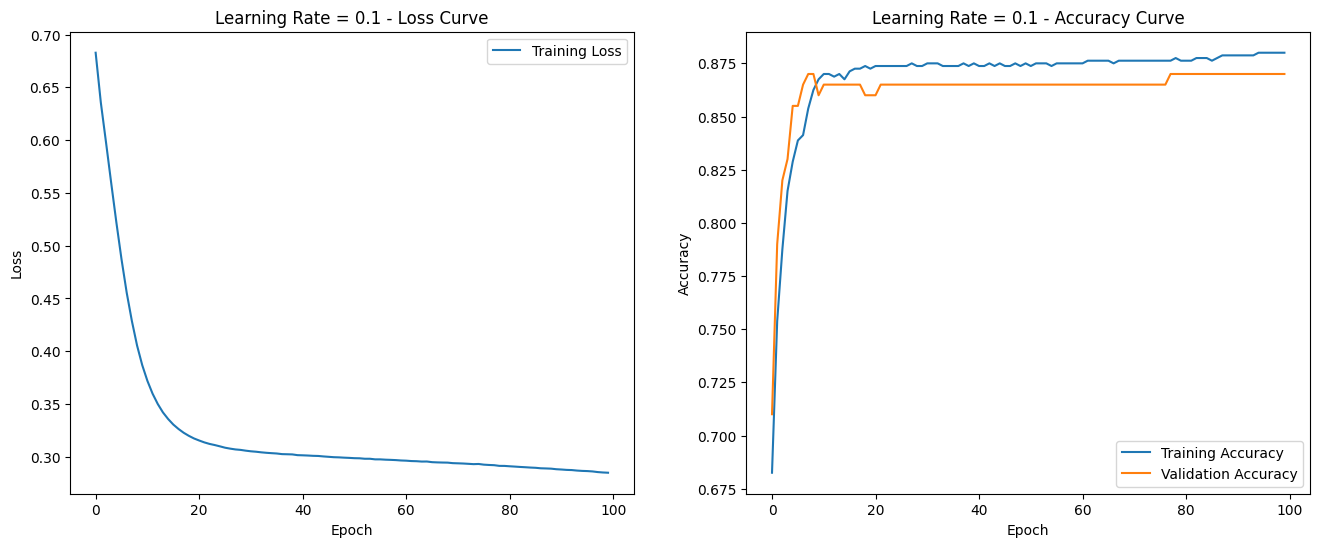

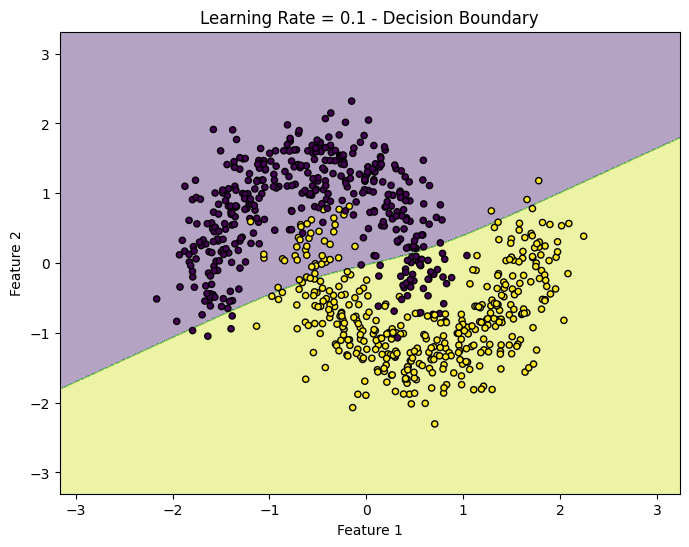


=== Experiment: Learning Rate = 0.01 ===
Parameters: {'epochs': 100, 'learning_rate': 0.01, 'batch_size': 32, 'verbose': False}

Training time: 0.27 seconds
Final Training Accuracy: 0.8688
Final Validation Accuracy: 0.8550


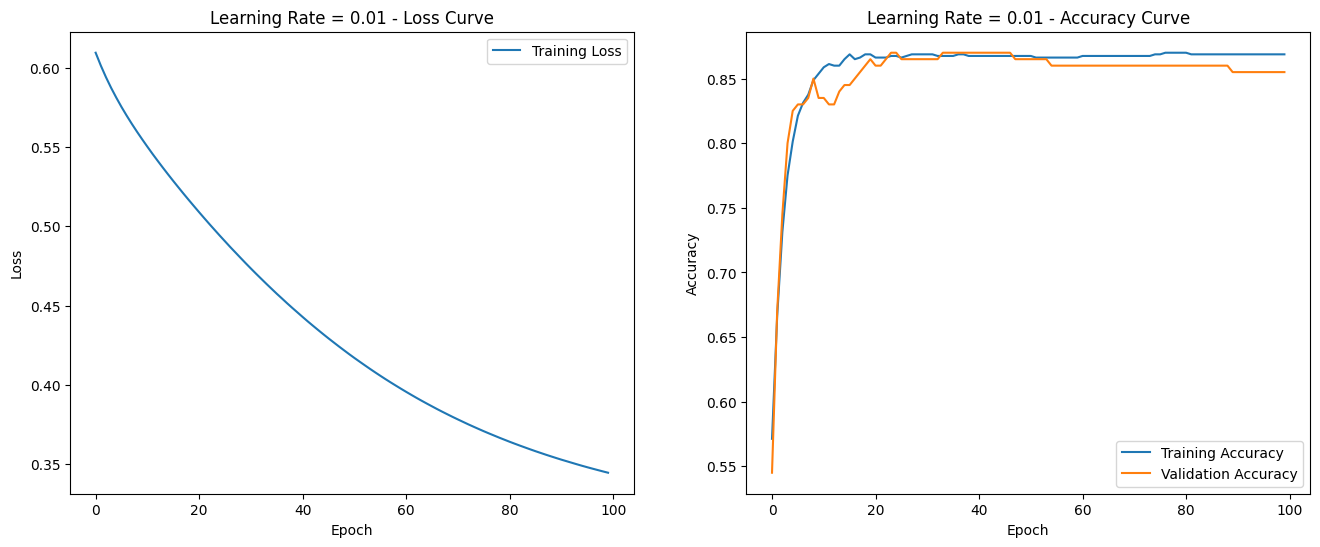

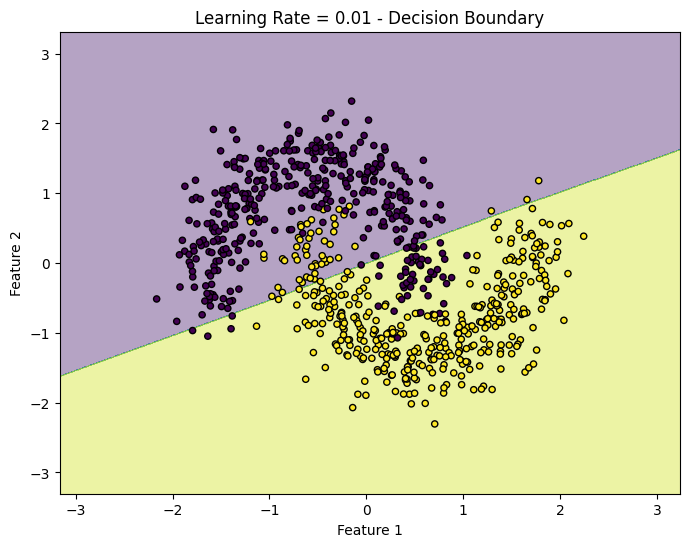


=== Experiment: Learning Rate = 0.001 ===
Parameters: {'epochs': 100, 'learning_rate': 0.001, 'batch_size': 32, 'verbose': False}

Training time: 0.30 seconds
Final Training Accuracy: 0.6388
Final Validation Accuracy: 0.6200


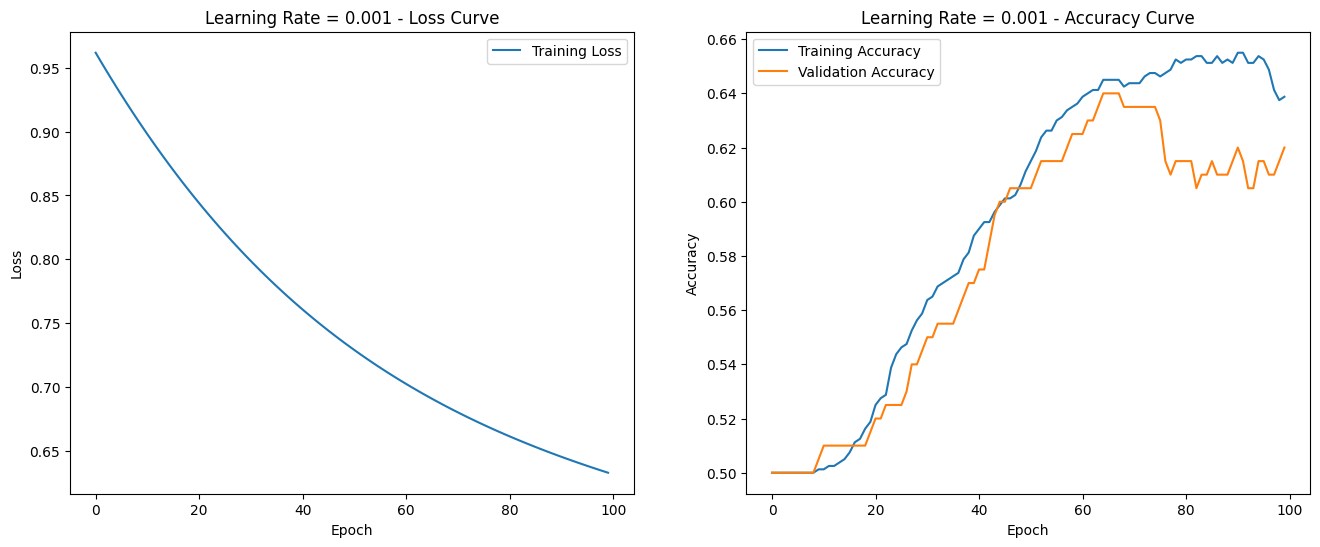

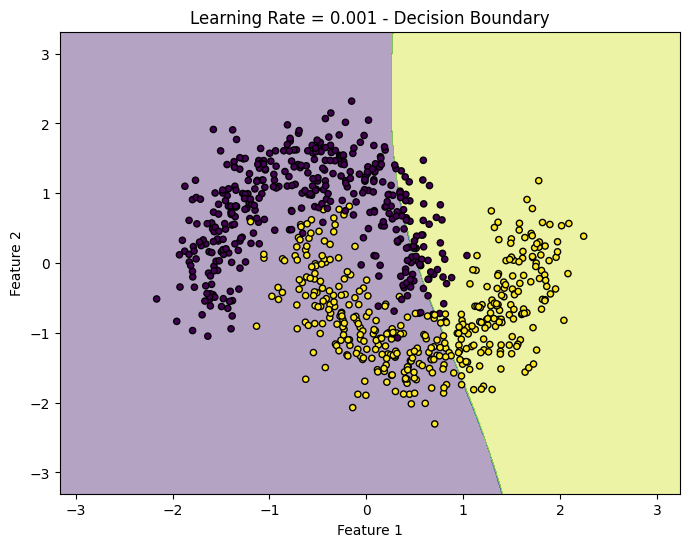


=== Experiment: Batch Size = 8 (LR=0.1) ===
Parameters: {'epochs': 100, 'learning_rate': 0.1, 'batch_size': 8, 'verbose': False}

Training time: 0.85 seconds
Final Training Accuracy: 0.8675
Final Validation Accuracy: 0.8700


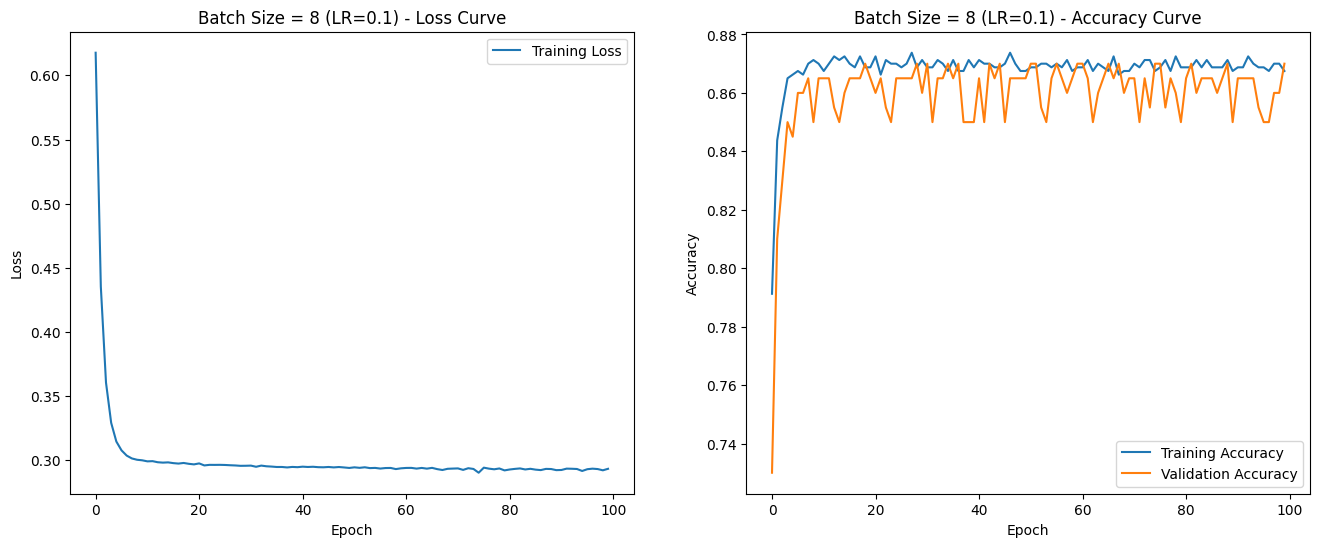

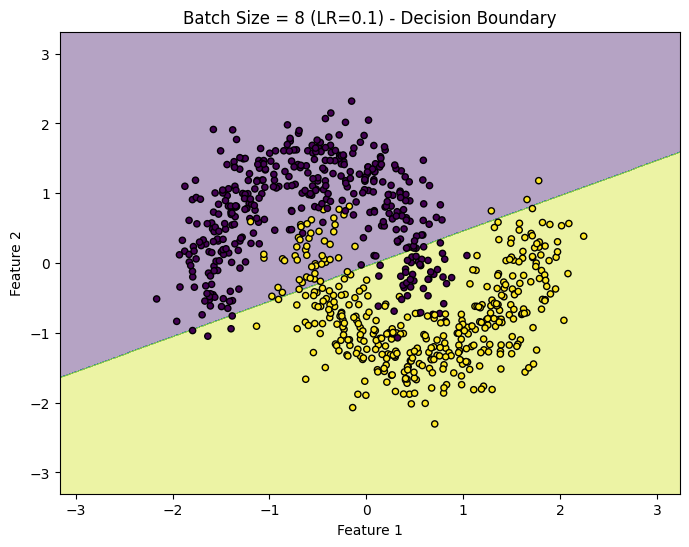


=== Experiment: Batch Size = 32 (LR=0.1) ===
Parameters: {'epochs': 100, 'learning_rate': 0.1, 'batch_size': 32, 'verbose': False}

Training time: 0.28 seconds
Final Training Accuracy: 0.8725
Final Validation Accuracy: 0.8600


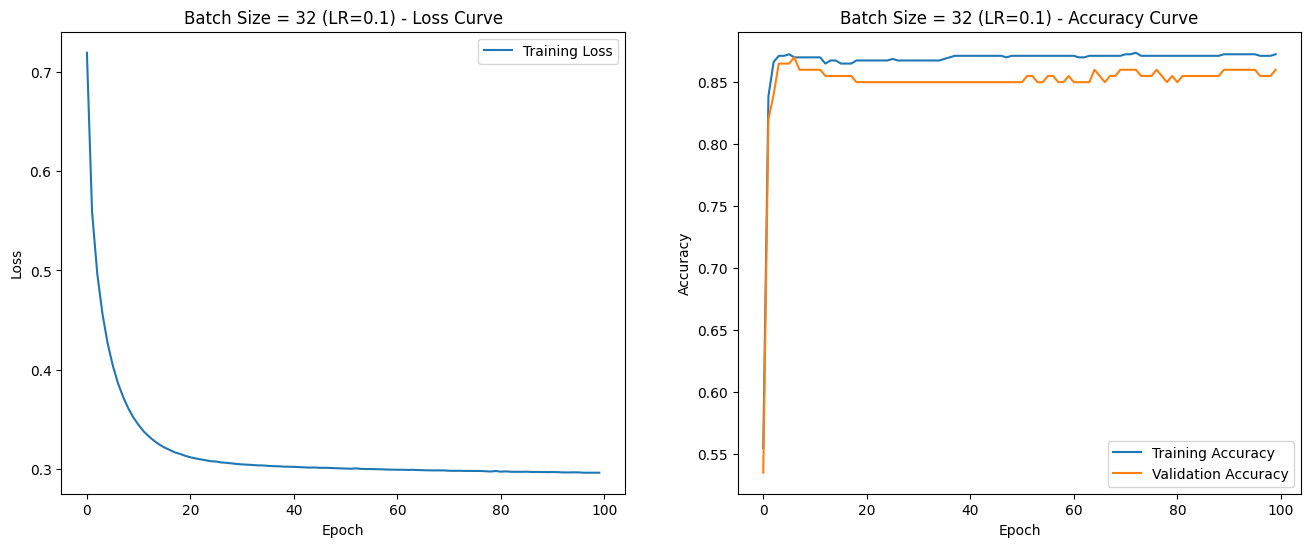

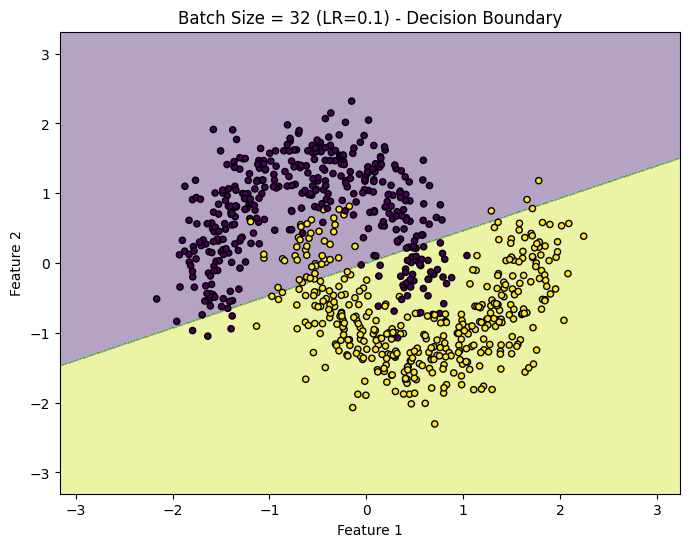


=== Experiment: Batch Size = 128 (LR=0.1) ===
Parameters: {'epochs': 100, 'learning_rate': 0.1, 'batch_size': 128, 'verbose': False}

Training time: 0.12 seconds
Final Training Accuracy: 0.8688
Final Validation Accuracy: 0.8650


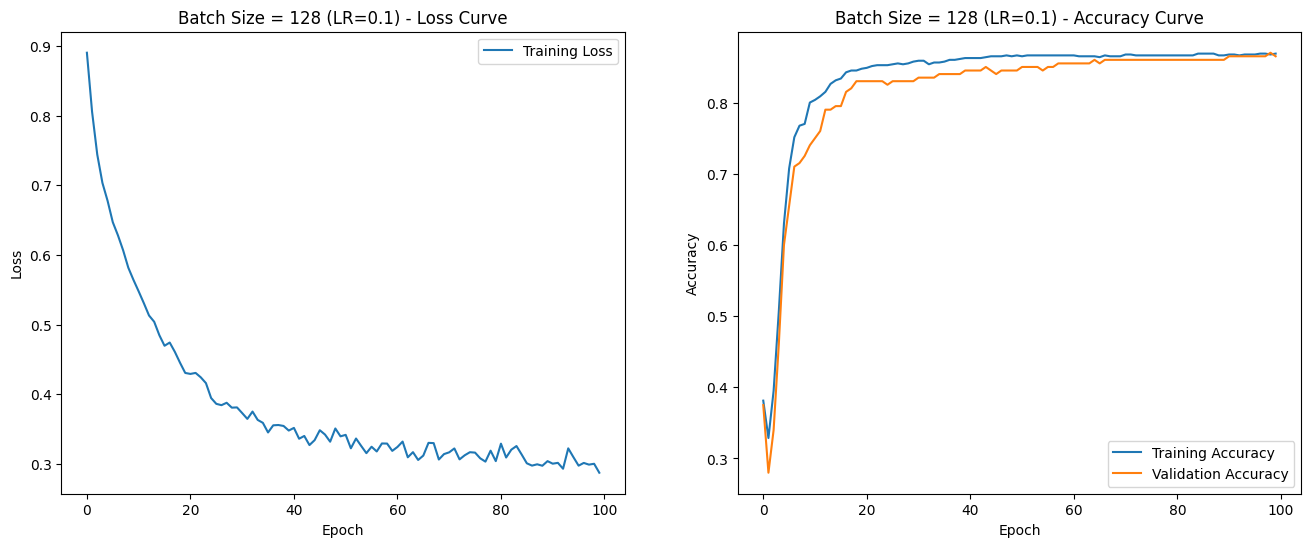

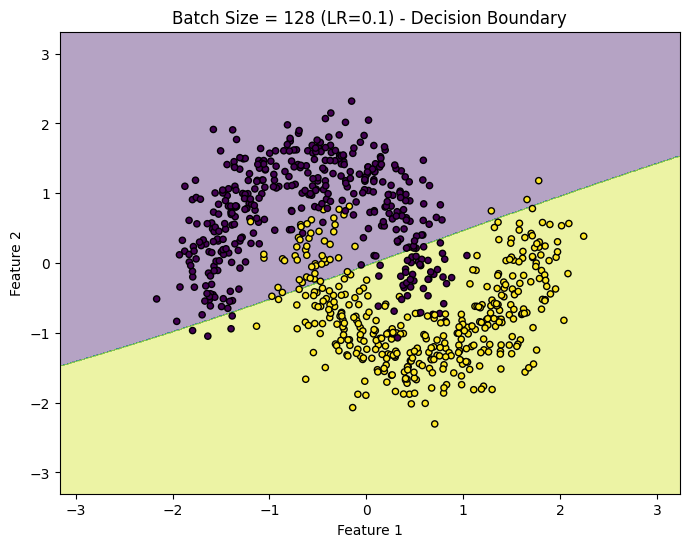


=== Experiment: Batch Size = 800 (LR=0.1) ===
Parameters: {'epochs': 100, 'learning_rate': 0.1, 'batch_size': 800, 'verbose': False}

Training time: 0.08 seconds
Final Training Accuracy: 0.8237
Final Validation Accuracy: 0.8550


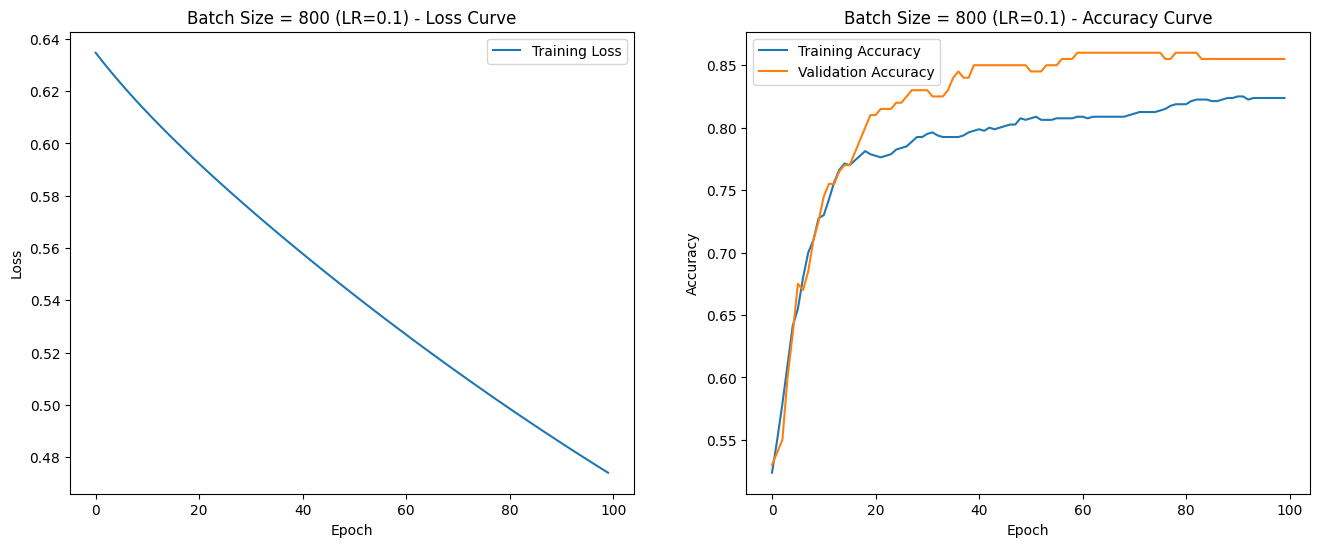

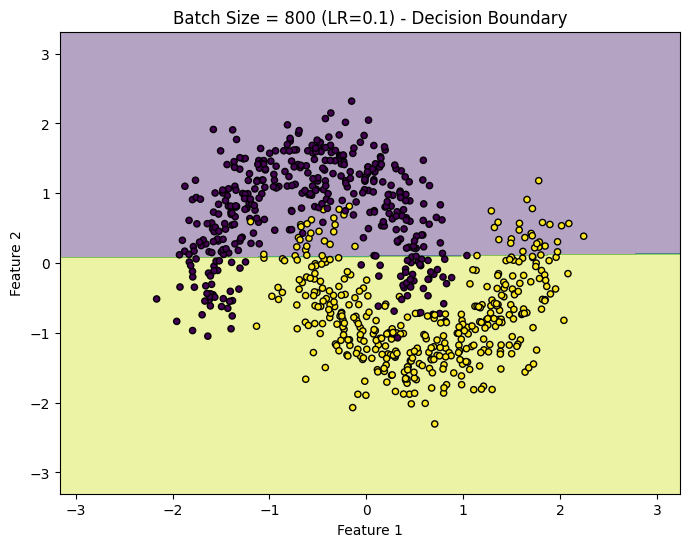


=== Experiment: Optimal Parameters ===
Parameters: {'epochs': 200, 'learning_rate': 0.05, 'batch_size': 16, 'verbose': True}
Epoch 1/200, Loss: 0.6470, Train Acc: 0.7113, Val Acc: 0.6650
Epoch 21/200, Loss: 0.3055, Train Acc: 0.8688, Val Acc: 0.8550
Epoch 41/200, Loss: 0.2986, Train Acc: 0.8688, Val Acc: 0.8500
Epoch 61/200, Loss: 0.2971, Train Acc: 0.8712, Val Acc: 0.8500
Epoch 81/200, Loss: 0.2961, Train Acc: 0.8712, Val Acc: 0.8550
Epoch 101/200, Loss: 0.2951, Train Acc: 0.8712, Val Acc: 0.8500
Epoch 121/200, Loss: 0.2947, Train Acc: 0.8712, Val Acc: 0.8500
Epoch 141/200, Loss: 0.2943, Train Acc: 0.8712, Val Acc: 0.8550
Epoch 161/200, Loss: 0.2936, Train Acc: 0.8712, Val Acc: 0.8550
Epoch 181/200, Loss: 0.2932, Train Acc: 0.8712, Val Acc: 0.8550
Epoch 200/200, Loss: 0.2927, Train Acc: 0.8712, Val Acc: 0.8550

Training time: 1.49 seconds
Final Training Accuracy: 0.8712
Final Validation Accuracy: 0.8550


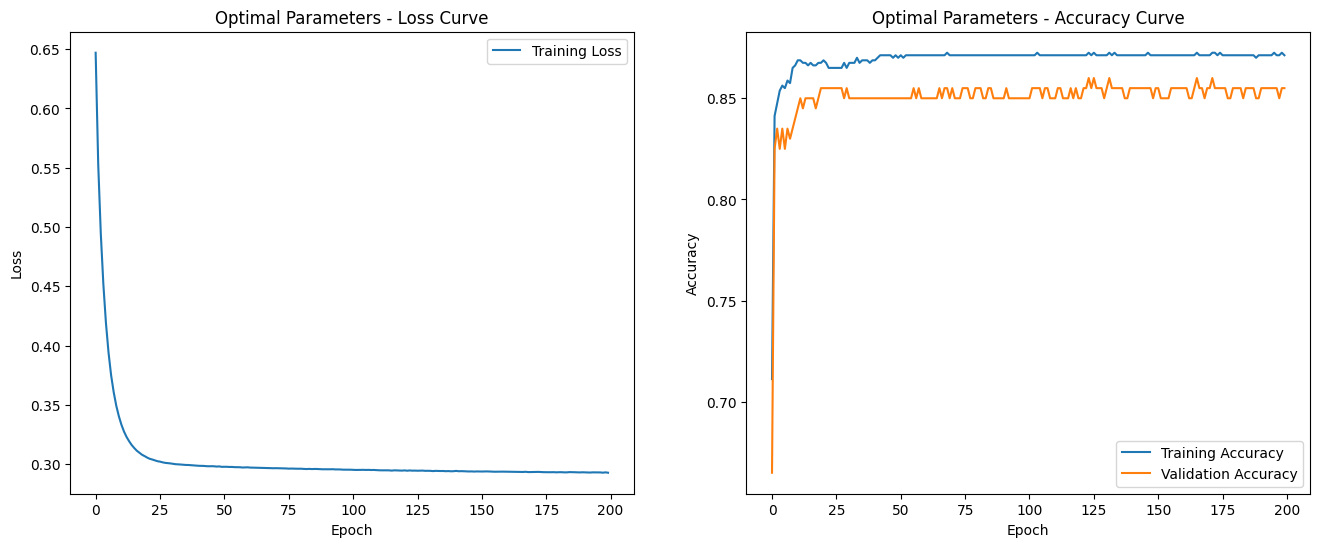

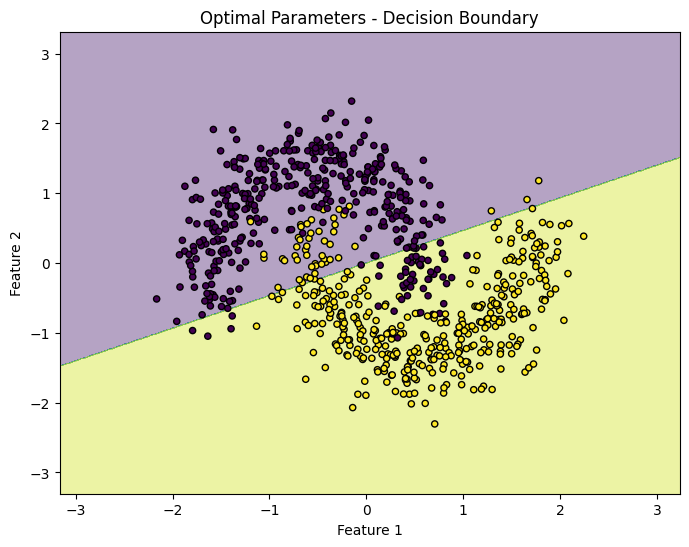

In [7]:
# =============================================
# Main Execution
# =============================================

if __name__ == "__main__":
    # Generate data
    X_train, X_val, y_train, y_val = generate_data(n_samples=1000, noise=0.2)

    # Experiment 1: Different learning rates
    learning_rates = [0.1, 0.01, 0.001]
    models = []

    for lr in learning_rates:
        params = {
            'epochs': 100,
            'learning_rate': lr,
            'batch_size': 32,
            'verbose': False
        }
        model = run_experiment(X_train, X_val, y_train, y_val, params,
                             f"Learning Rate = {lr}")
        models.append(model)

    # Experiment 2: Different batch sizes
    batch_sizes = [8, 32, 128, X_train.shape[0]]  # Last one is full batch GD

    for bs in batch_sizes:
        params = {
            'epochs': 100,
            'learning_rate': 0.1,
            'batch_size': bs,
            'verbose': False
        }
        model = run_experiment(X_train, X_val, y_train, y_val, params,
                             f"Batch Size = {bs} (LR=0.1)")
        models.append(model)

    # Experiment 3: Combined effect
    params = {
        'epochs': 200,
        'learning_rate': 0.05,
        'batch_size': 16,
        'verbose': True
    }
    best_model = run_experiment(X_train, X_val, y_train, y_val, params,
                              "Optimal Parameters")